This post is about how to perform a Bayesian analysis of election polls for USA 2016 presidential election.
In previous posts, I have discussed how to make a poll for a single State (Nevada as example). Here we will use some simple Python functions to compue the probability for Clinton of winning in all 51 States (State-by-State).
I will make use of near-prior ignorance models that were introduced in a past post.

As first step, we load the data from an Excel file that includes 51 sheet (one per state) with the election poll data

In [6]:
import pandas as pd
import os
xl_file = pd.ExcelFile('StatePoll_august28.xlsx')
df = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}


The following function implements the **Covariance Intersection** discussed in the post http://idpstat.blogspot.ch/2016/08/combining-polls-data-from-different.html

In [7]:
def covariance_intersection(sample,A,B):
    #A is the first candidate
    #B is the second candidate
    #sample is the samplesize
    Af=0
    Bf=0
    Samplef=0
    for i in range(0,len(A)):
        Af=Af+A[i]*sample[i]/len(A)
        Bf=Bf+B[i]*sample[i]/len(A)
        Samplef=Samplef+sample[i]/len(A)
    Af=Af/Samplef
    Bf=Bf/Samplef    
    return list((Samplef,Af,Bf))

We implement the Bayesian election forecast using the multinomial-Dirichlet model with near-ignorance priors discussed in http://idpstat.blogspot.ch/2016/08/blog-post_9.html for Nevada. Here the procedure is applied to all States. The following loop computes the poll state-by-state and save the resulting posterior lwoer and upper distirbutions in png files



In [8]:
#define the function of interest for Bayesian inference
def g(theta):
    #x is a numpy vector
    return (theta[:,0]-theta[:,1])

#function that computes the posterior sampels
def compute_posterior_samples(ap,Np):
    #ap: posterior Dirichlet distribution vector parameters
    #Np: number of MC samples
    return np.random.dirichlet(ap,Np) #we use numpy

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#number of MC samples
Np=10000
#pseudo-votes for Near-Ignorance Priors
c=2

df_res = pd.DataFrame(index=np.arange(0, 51),columns=('LowerProbability', 'UpperProbability'))
Statesind=0
for key, value in sorted(df.items()):
    Statesind=Statesind+1
    #compute the list of fused polls
    fus=covariance_intersection(df[key]['SAMPLE'].values,df[key]['Clinton'].values,df[key]['Trump'].values)
    #print(df['alaska']['Sample'].values)
    #print(df['alaska']['Clinton'].values)
    #print(df['alaska']['Trump'].values)
    #data from the poll
    datapoll=np.array([fus[0]*fus[1],fus[0]*fus[2],fus[0]*(1-fus[1]-fus[2])])
    #prior for a swing scenario in favor of Clinton
    au=np.array([c,-c,0])
    #prior for a swing scenario in favor of Trump
    al=np.array([-c,c,0])

    #compute the lower and upepr distirbutions for the two swing scenarios
    postsampleslower = compute_posterior_samples(datapoll+al,Np)
    postsamplesupper = compute_posterior_samples(datapoll+au,Np)
    #Compute the lower and upepr probabilities
    problower=sum(g(postsampleslower)>0)/Np
    probupper=sum(g(postsamplesupper)>0)/Np
    df_res.loc[Statesind-1] =[problower,probupper]
    
    # Plot the figs and save to temp files
    sns.distplot(g(postsampleslower), axlabel="Clinton-Trump", 
                 kde=True, hist=True,color='darkred') #, hist_kws={"range": [-1,1]}
    go=sns.distplot(g(postsamplesupper), 
                 kde=True, hist=True,color='darkblue') #, hist_kws={"range": [-1,1
    
    go.set_title(key+'    ['+str(problower)+','+str(probupper)+']')
    plt.axvline(x=0.,color='g')
    namefile='./plots/f'+str(Statesind)+'.png'
    plt.savefig(namefile); 
    plt.close();
    
df_res.to_csv('LowerUpper.csv')


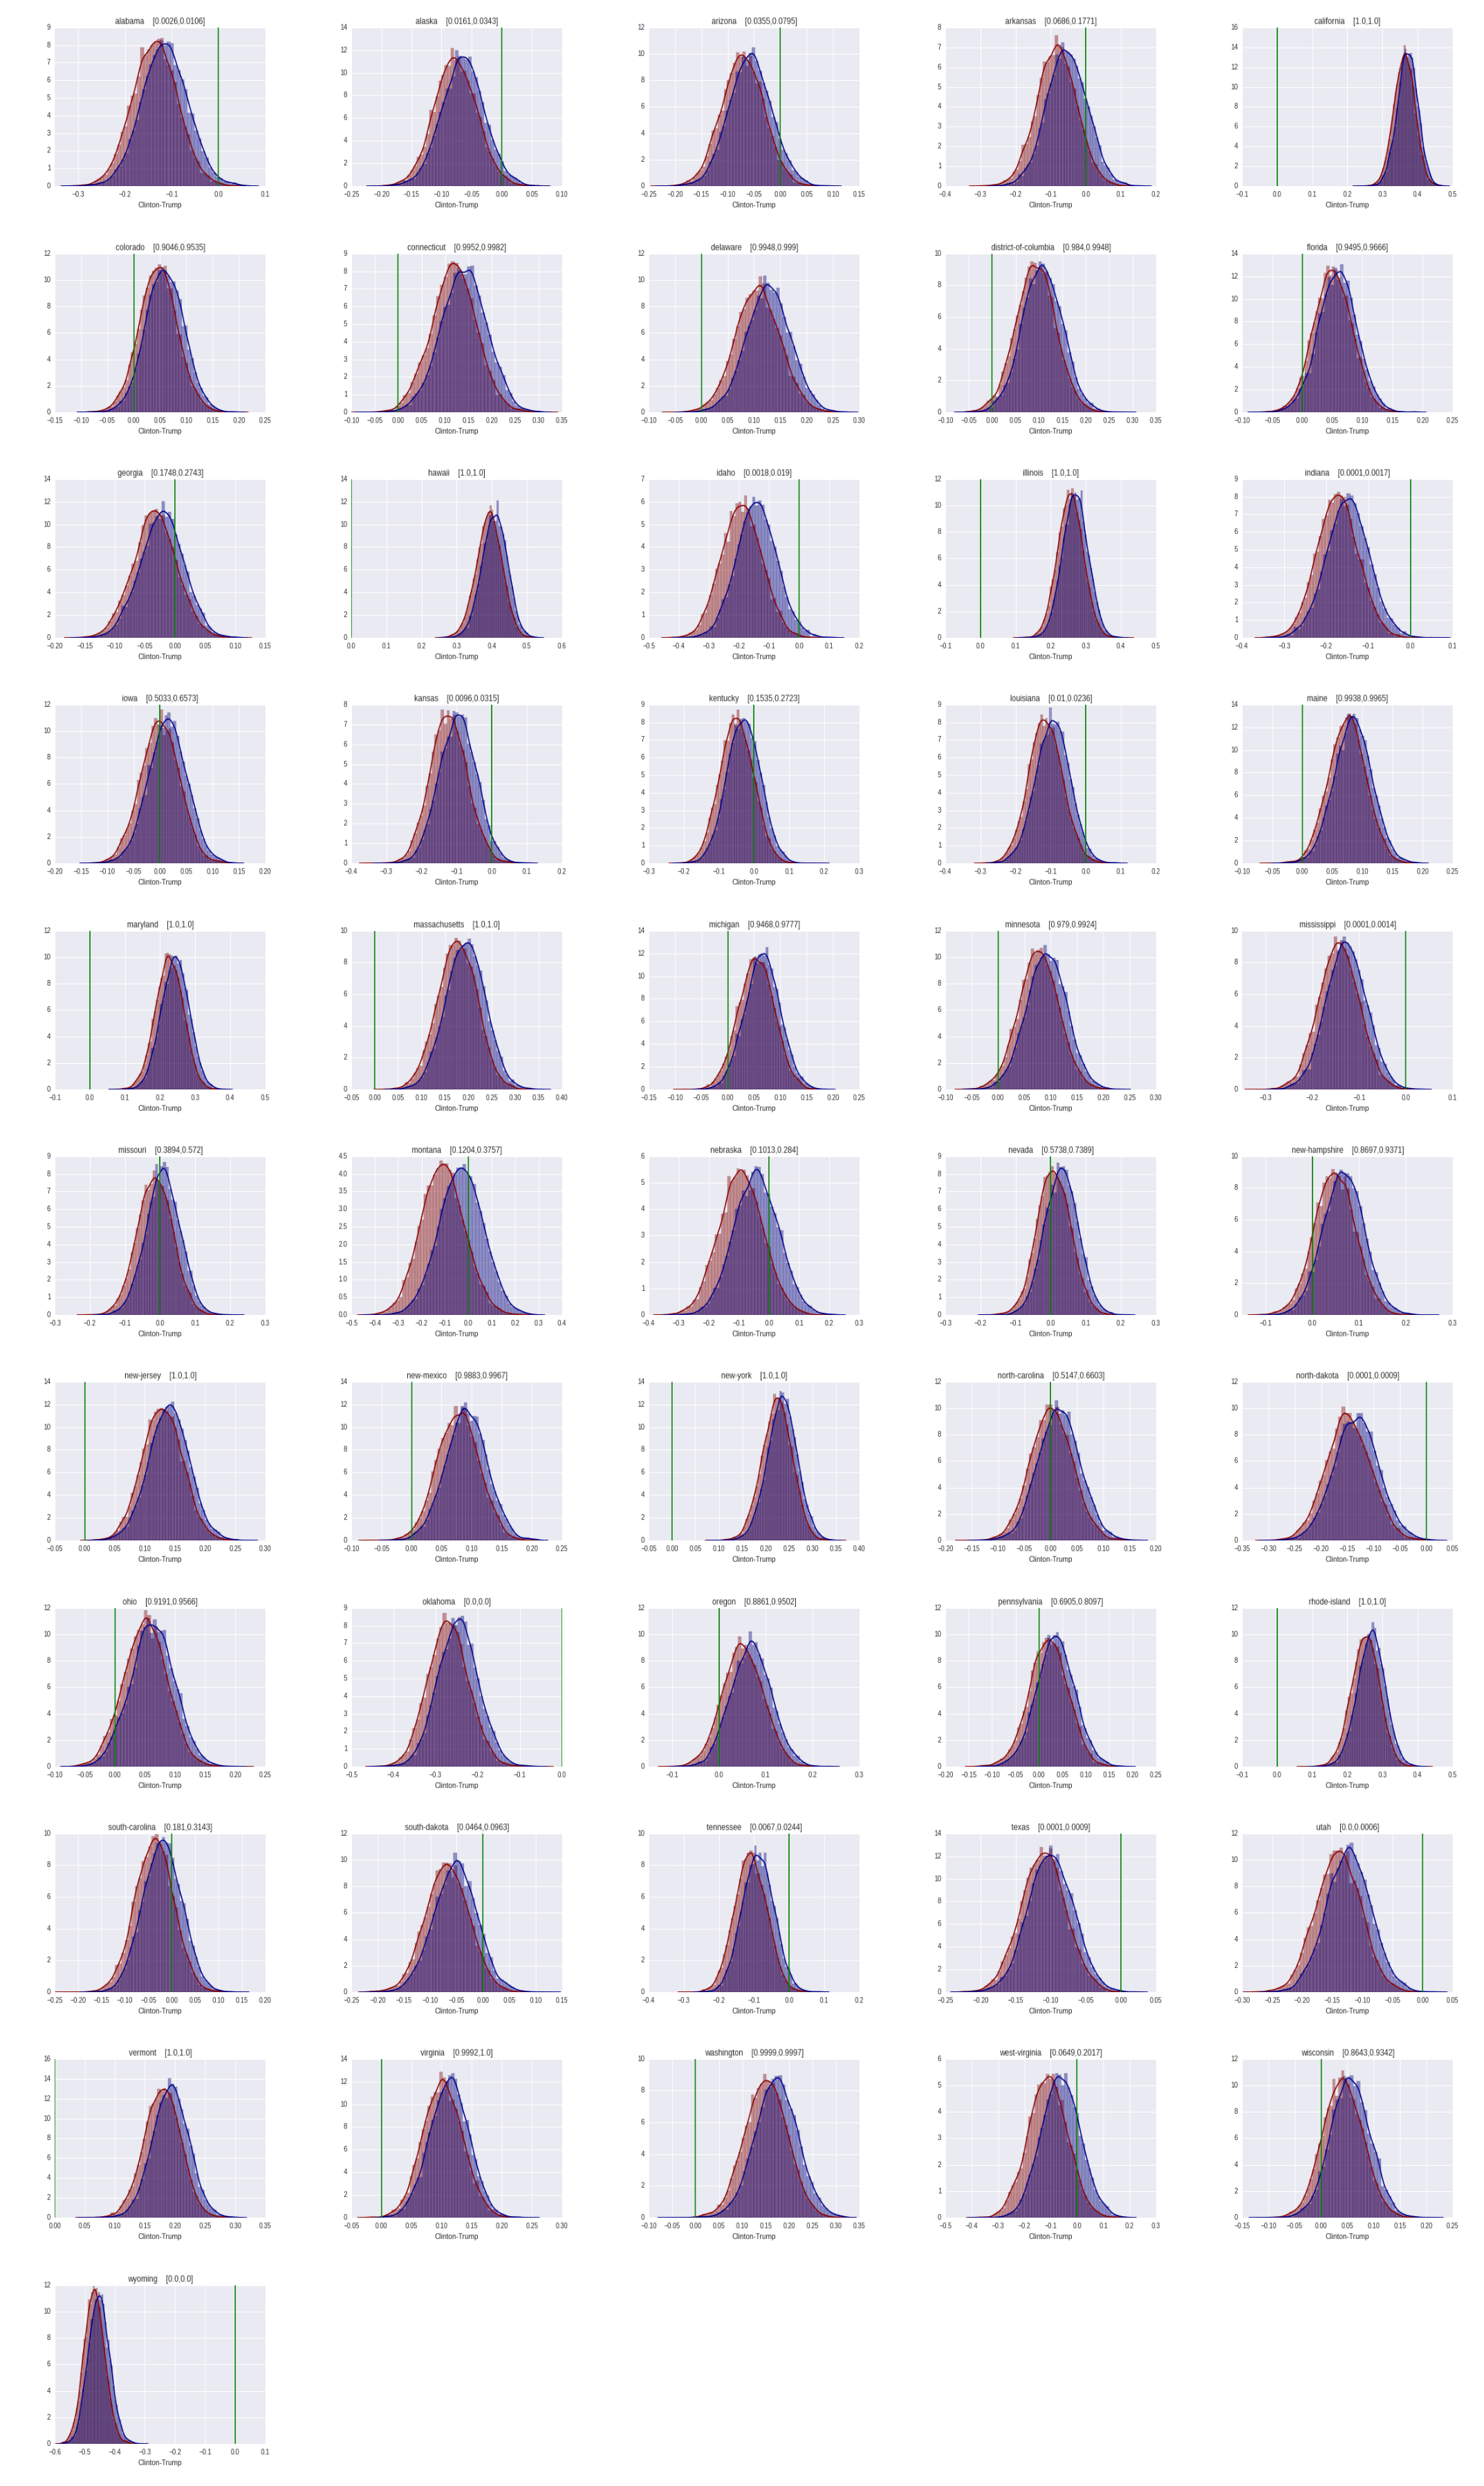

In [9]:
# Combine them with imshows
fig, ax = plt.subplots(11,5, figsize=(30,50))
count=0
for i1 in range(0,11):
    for i2 in range(0,5):
        count=count+1
        if count>51:
            ax[i1,i2].set_visible(False)
        else:
            ax[i1,i2].imshow(plt.imread('./plots/f%s.png' %count), aspect='auto'); ax[i1,i2].axis('off')
            plt.tight_layout()
            
plt.savefig('AllStates')
plt.show()


The green line represents the "even-line". We have therefore three different situaions:
1. both lower and upper distributions are (almost all) to the right of the green line (these are the States that are clearly for Clinton);
2. both lower and upper distributions are (almost all) to the left of the green line (these are the States that are clearly for Trump);
3. States where the lower and upper distributions are across the line.

For instance, States that are clearly for Clinton are California, Connecticut, Delaware, etc. while States that are for Trump are Alabama, Alaska, Arizona etc.. The values of the lower and upepr probability of winning the State for Clinton are reported in the top of the plots. 
One of advantages of near-prior ignorance model is that they allow us to automatically detect the States that are more uncertain, i.e., States where a small change  of the vote intention can dramatically change the final result.
Let us consider for instance the undecided State 'North-Carolina' (it is undecided because the lower and upper probabilitie are 0.52 and 0.66). It can be observed that a change of the vote of only 2 people from Clinton to Trump (that is 0.4% of the poll sample size) reduces Clinton's  probability of winning  to 0.52. 

The other **undecided States** are
* Iowa [0.50,0.64]
* Missouri [0.38, 0.56]
* Nevada [0.58, 0.74]
* North-Carolina [0.52,0.66]

We are almost ready to compute the general election result, in the next post.